<a href="https://colab.research.google.com/github/puneat/Algorithmic_Portfolio/blob/puneet/Portfolio_Investment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler

In [ ]:
sp500_hist_data = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/close_price.csv')
sp500_companies = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/company_data.csv')
secondary_index_data = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/secondary_data.csv')

In [ ]:
def read_price_data(idx):
  open = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/open_price.csv')
  close = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/close_price.csv')
  high = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/high_price.csv')
  low = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/low_price.csv')
  bb_live = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/bb_live.csv')
  volume = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/volume.csv')

  open=open.iloc[:,[0,idx]]
  close=close.iloc[:,[0,idx]]
  high=high.iloc[:,[0,idx]]
  low=low.iloc[:,[0,idx]]
  bb_live=bb_live.iloc[:,[0,idx]]
  volume=volume.iloc[:,[0,idx]]

  open=open.set_index('date')
  close=close.set_index('date')
  high=high.set_index('date')
  low=low.set_index('date')
  bb_live=bb_live.set_index('date')
  volume=volume.set_index('date')

  result = pd.concat([open,high,low,close,volume,bb_live], axis=1).reindex(bb_live.index)
  result.columns = ['open','high','low','close','volume','bb_live'] 
  return result

In [ ]:
def data_load(idx):
  ind=secondary_index_data
  ind=ind.dropna()
  equity=sp500_hist_data.iloc[:,[0,idx]]
  missing_values = set(ind.iloc[:, 0]).symmetric_difference(set(equity.iloc[:, 0]))
  missing_values=list(missing_values)
  #print(len(missing_values))
  ind = ind[~ind['date'].isin(missing_values)]
  equity = equity[~equity['date'].isin(missing_values)]
  ind=ind.iloc[:,1:]
  equity=equity.iloc[:,-1]
  return ind, equity

In [ ]:
#creating a corr matrix wrt to class labels
corr_matrix=[]
for idx in range(1,ind.shape[1]): 
  corr=np.corrcoef(ind.iloc[:,idx].to_numpy(),equity['AAPL.US Equity'].to_numpy())
  #print(corr)
#Converting coeeficient to percentage
  corr_matrix.append(corr[0,1]*100)
#print(corr_matrix)

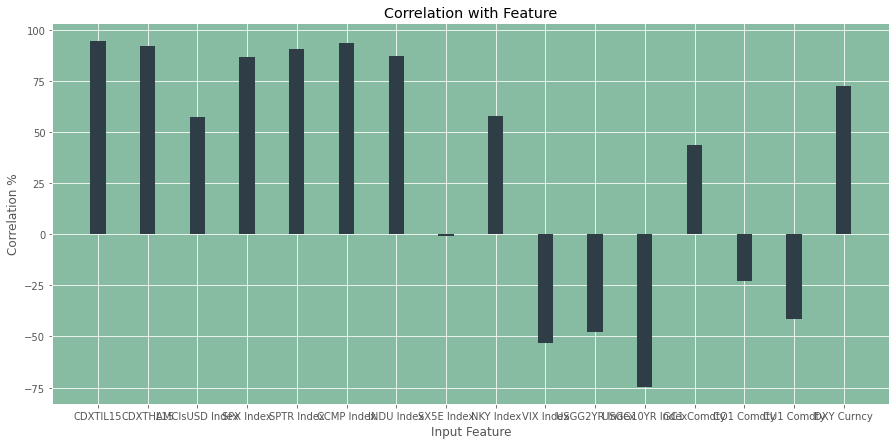

In [ ]:
#plotting the correlation for every variable wrt class
matplotlib.style.use('ggplot')
fig = plt.figure(facecolor='w',figsize=(15,7)) # creating a plot figure
ax = fig.add_subplot(111, axisbelow=True,facecolor='#87bba2')
cols = np.linspace(1, 40, 16)
ax.bar(cols,corr_matrix,color='#2f3e46',tick_label=ind.columns[1:])
ax.set_title('Correlation with Feature')
ax.set_xlabel('Input Feature')
ax.set_ylabel('Correlation %')
plt.show()

In [ ]:
#model parameters
param = {'num_leaves':100, 'objective':'mse','max_depth':7,'learning_rate':0.1,'max_bin':20, 'seed':15, 'verbose': -1}
param['metric'] = ['mse']

#model variables initialisation
model=None
evals_result = {} #store batch results
cum_results = {'training':[], 'valid_1':[]} #store all results

In [ ]:
#training loop
trainValidSplit = 0.75
roundPerBatch = 1000
trainx=ind.to_numpy()
trainy=equity.to_numpy()

In [ ]:
def input_data(ind,equity):
  trainx=ind.to_numpy()
  trainy=equity.to_numpy()
  trainX, trainY = trainx[400:,:], trainy[400:]
  validX, validY = trainx[:400,:], trainy[:400]
  scaler = StandardScaler()
  trainX=scaler.fit_transform(trainX)
  validX=scaler.transform(validX)
  return trainX, trainY, validX, validY

In [ ]:
#training loop
#build training and validation gbm dataset objects
for i in range(43,44):
  ind, equity = data_load(i)
  trainX, trainY, validX, validY = input_data(ind,equity)
  train_data = lgb.Dataset(trainX, label=trainY)
  validation_data = lgb.Dataset(validX,label=validY)
  #train model
  model = lgb.train(param, train_data, roundPerBatch,
                      valid_sets=[train_data, validation_data],
                      evals_result=evals_result,
                      verbose_eval=1,init_model=model)
  cum_results['training'] += (evals_result['training']['l2'])
  cum_results['valid_1'] += (evals_result['valid_1']['l2'])
  #if i != int((sp500_hist_data.shape[1]/2)-1):
   # del ind,equity,trainX, trainY, validX, validY,train_data,validation_data

[1]	training's l2: 31080.1	valid_1's l2: 52611.8
[2]	training's l2: 25302.6	valid_1's l2: 50306.9
[3]	training's l2: 20618.6	valid_1's l2: 46884.5
[4]	training's l2: 16816.5	valid_1's l2: 45530
[5]	training's l2: 13739.3	valid_1's l2: 42550.8
[6]	training's l2: 11236.9	valid_1's l2: 40942
[7]	training's l2: 9205.45	valid_1's l2: 36578.7
[8]	training's l2: 7560.54	valid_1's l2: 33019.8
[9]	training's l2: 6224.83	valid_1's l2: 30503.3
[10]	training's l2: 5137.92	valid_1's l2: 27892.5
[11]	training's l2: 4255.05	valid_1's l2: 25656.6
[12]	training's l2: 3530.67	valid_1's l2: 23737.2
[13]	training's l2: 2941.41	valid_1's l2: 22385.7
[14]	training's l2: 2462.25	valid_1's l2: 20945.5
[15]	training's l2: 2071.36	valid_1's l2: 20011.8
[16]	training's l2: 1752.66	valid_1's l2: 19319.4
[17]	training's l2: 1490.93	valid_1's l2: 18611.5
[18]	training's l2: 1279.25	valid_1's l2: 18032.1
[19]	training's l2: 1103.86	valid_1's l2: 17564.9
[20]	training's l2: 944.273	valid_1's l2: 17140.4
[21]	training

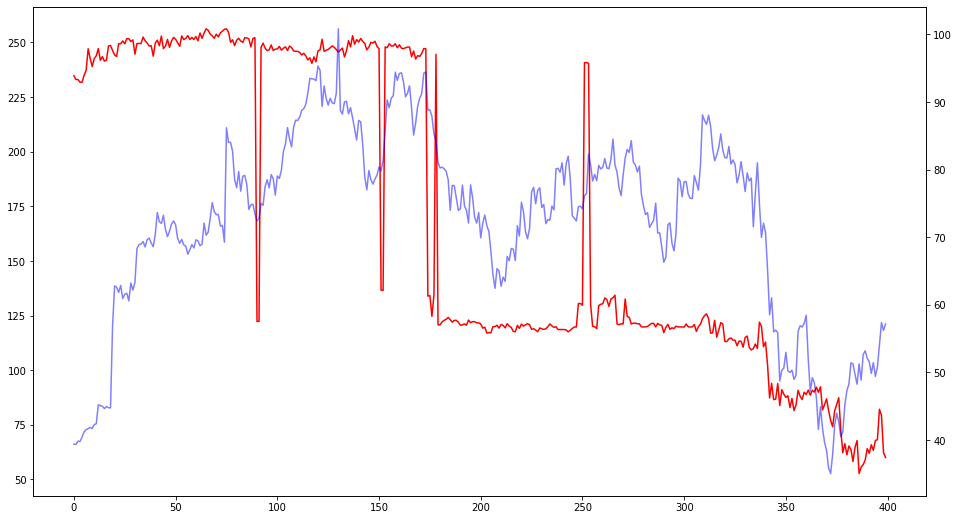

In [ ]:
ypred = model.predict(validX)

fig, ax1 = plt.subplots(figsize=(16, 9))
ax2 = ax1.twinx()
ax1.plot(ypred,color='red')
ax2.plot(validY,color='blue',alpha=0.5)

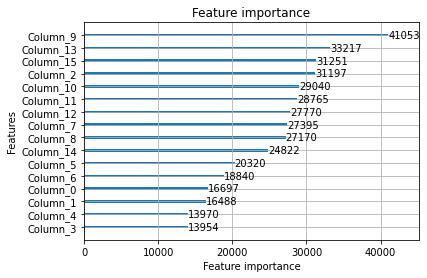

In [ ]:
lgb.plot_importance(model, max_num_features=16);